In [2]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import time

2.13.0


In [3]:
# funciones que nos van a ayudar

# normaliza un conjunto de datos
def norm(x, st):
    return((x - st['mean'])/st['std'])

# un plot de la historia del ajuste
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mse'],'b',
           label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show() # un €


In [4]:
# Especificamos la direccion donde esta el fichero y su nombre y como lo queremos guardar
dataset_path = tf.keras.utils.get_file("auto-mpg.data",
                                       "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")


   8192/Unknown - 0s 0us/step

In [5]:
# El csv viene sin ninguna cabezera estos son los nombres de las variables
column_names = ['MPG', 'Cylinders','Displacement','Horsepower','Weight','Acceleration','Model year','Origin']

# se lee el fichero
data = pd.read_csv(dataset_path, names=column_names, na_values="?",
                          comment='\t', sep=" ", skipinitialspace=True)

In [6]:
# vemos las primeras filas de los datos
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
# PREPROCESAMIENTO --------------------

# El fichero tiene datos perdidos y hay que eliminar las filas donde estan
data = data.dropna() 

# La variable origin viene codificada de forma numerica pero la pasamos a un one hot

# no te preocupes por este codigo, cosas de python
o = data.pop('Origin')
data['USA'] = (o == 1)*1.0
data['Europe'] = (o == 2)*2.0
data['Japan'] = (o == 3)*3.0

# comprobamos que ahora tenemos una variable para cada pais de origen
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


In [8]:
# Como el train y test sets no estan creados los creamos ahora aleatoriamente

x_train = data.sample(frac=0.8, random_state=0)
x_test = data.drop(x_train.index)

y_train = x_train.pop('MPG')
y_test = x_test.pop('MPG')

In [9]:
x_train.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,3.0


In [10]:
y_train.head()

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

In [11]:
# calculamos los estadisticos descriptivos para x_train
x_train_stats = x_train.describe().transpose()
x_train_stats.head()

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8


In [12]:
# calculamos los estadisticos descriptivos para x_test
x_test_stats = x_test.describe().transpose()
x_test_stats.head()

,count,mean,std,min,25%,50%,75%,max
Cylinders,78.0,5.448718,1.740633,3.0,4.00,4.00,8.00,8.0
Displacement,78.0,190.762821,106.494733,70.0,98.00,138.00,292.00,400.0
Horsepower,78.0,102.858974,40.255265,48.0,74.25,90.00,121.75,230.0
Weight,78.0,2926.589744,874.900416,1613.0,2159.50,2692.50,3706.50,4746.0
Acceleration,78.0,15.469231,2.649298,8.5,13.70,15.25,17.00,22.2


In [13]:
# normalizamos x_train y x_test

x_train_norm = norm(x_train, x_train_stats)
x_train_norm.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


In [14]:
x_test_norm = norm(x_test, x_test_stats)
x_test_norm.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
9,1.465721,1.870864,2.164711,1.055446,-2.630595,-1.694775,0.764362,-0.423659,-0.524515
25,1.465721,1.589160,2.785748,1.929831,-0.554574,-1.694775,0.764362,-0.423659,-0.524515
28,1.465721,1.063312,2.239236,2.063561,1.143989,-1.694775,0.764362,-0.423659,-0.524515
31,-0.832294,-0.730203,-0.195228,-0.798479,-0.554574,-1.426091,-1.291508,-0.423659,1.882082
33,0.316714,0.387223,-0.071021,-0.334426,-0.932032,-1.426091,0.764362,-0.423659,-0.524515


In [15]:
# comprobamos que lo hemos hecho bien

x_train_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,1.824443e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,8.627211e-17,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-9.900078e-18,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-8.485781e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,-5.148041e-16,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model year,314.0,9.772791e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,7.920062e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,1.980016e-17,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,-2.262875e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


In [16]:
# Modelo --------------------------


# Configuramos la topología

model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape=[( len(x_train_norm.keys()) )]))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9025 (35.25 KB)
Trainable params: 9025 (35.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# compilamos

model.compile(loss='mse',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics = ['mse','mae'])

In [18]:
# entrenamos
start = time.time()
history = model.fit(x_train_norm, y_train,
                    epochs = 300,
                    validation_split = 0.2,  # divide automaticamente el train
                                             # en train (80%) y dev (20%)
                    verbose = 0) # para evitar que se llene toda la pantalla

end = time.time()
print('Tiempo de ejecución:', end - start)

Tiempo de ejecución: 12.021100759506226


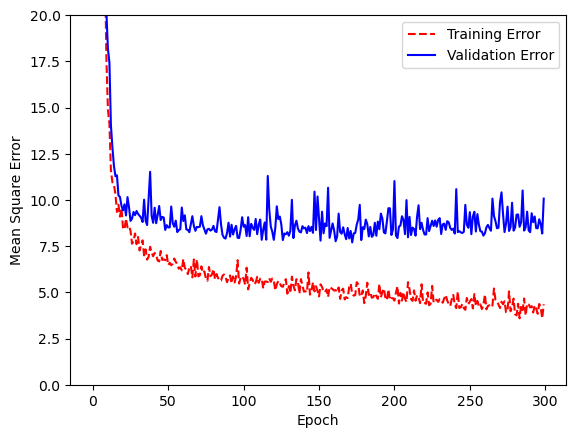

In [19]:
# Un grafico para ver el ajuste en los dos sets

plot_history(history)

In [20]:
# Evaluamos el modelo con el conjunto de validacion
model.evaluate(x_test_norm, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 6.1984 - mse: 6.1984 - mae: 1.9972


[6.198376178741455, 6.198376178741455, 1.9971569776535034]

3/3 [==============================] - 0s 5ms/step


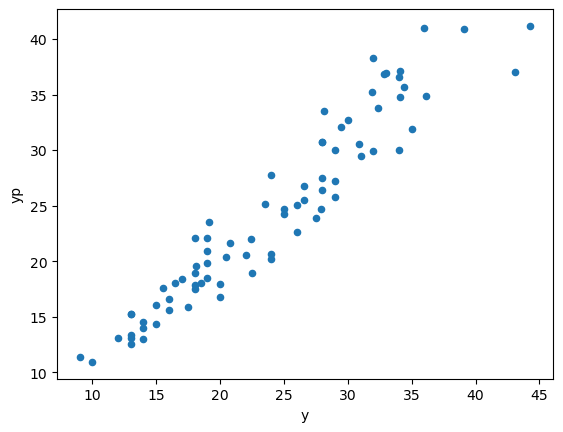

In [21]:
# Como las variables son cuantitativas un grafico de dispersion podría estar perfecto

yp = model.predict(x_test_norm)


df = pd.DataFrame({'y': y_test, 'yp': yp.flatten()})
df.plot.scatter(x='y', y='yp')
plt.show()